# Learn Probability Density Functions using Roll-Number-Parameterized Non-Linear Model

**Dataset:** India Air Quality Data (NO2 feature)  
**Link:** https://www.kaggle.com/datasets/shrutibhargava94/india-air-quality-data

## Objective
1. Transform NO2 data using roll-number-parameterized function
2. Learn parameters (λ, μ, c) of the PDF: $p(z) = c \cdot e^{-\lambda(z-\mu)^2}$
3. Submit the learned parameters

In [4]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize, curve_fit
from scipy.integrate import quad
import seaborn as sns

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

# Set random seed
np.random.seed(42)

## Step 0: Configuration - Enter Your Roll Number

In [5]:
ROLL_NUMBER = 102317147

# Calculate transformation parameters
ar = 0.05 * (ROLL_NUMBER % 7)
br = 0.3 * (ROLL_NUMBER % 5 + 1)

print(f"Roll Number: {ROLL_NUMBER}")
print(f"ar = 0.05 × ({ROLL_NUMBER} mod 7) = {ar:.6f}")
print(f"br = 0.3 × ({ROLL_NUMBER} mod 5 + 1) = {br:.6f}")

Roll Number: 102317147
ar = 0.05 × (102317147 mod 7) = 0.100000
br = 0.3 × (102317147 mod 5 + 1) = 0.900000


## Step 1: Load and Explore Data

In [7]:
import pandas as pd
import numpy as np

# Load the dataset
# Download from: https://www.kaggle.com/datasets/shrutibhargava94/india-air-quality-data

try:
    data = pd.read_csv('/content/data.csv', encoding='latin1')
    print("Dataset loaded successfully!")
    print(f"Shape: {data.shape}")
    print(f"\nFirst few rows:")
    display(data.head())

    # Print all column names to help identify the correct NO2 column
    print(f"\nAvailable columns: {data.columns.tolist()}")

    # Extract NO2 data and remove NaN values
    x = data['no2'].dropna().values
    print(f"\nNO2 Statistics:")
    print(f"  Count: {len(x)}")
    print(f"  Mean:  {np.mean(x):.2f}")
    print(f"  Std:   {np.std(x):.2f}")
    print(f"  Min:   {np.min(x):.2f}")
    print(f"  Max:   {np.max(x):.2f}")

except FileNotFoundError:
    print("WARNING: Dataset not found!")
    print("Using simulated NO2 data for demonstration.")
    print("Please download the actual dataset from Kaggle.")

    # Generate sample data
    x = np.random.gamma(2, 20, 5000)
    print(f"\nSimulated NO2 Statistics:")
    print(f"  Count: {len(x)}")
    print(f"  Mean:  {np.mean(x):.2f}")
    print(f"  Std:   {np.std(x):.2f}")

Dataset loaded successfully!
Shape: (435742, 13)

First few rows:


/tmp/ipython-input-3477929042.py:8: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/content/data.csv', encoding='latin1')


,stn_code,sampling_date,state,location,agency,type,so2,no2,rspm,spm,location_monitoring_station,pm2_5,date
0,150.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",4.8,17.4,NaN,NaN,NaN,NaN,1990-02-01
1,151.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,3.1,7.0,NaN,NaN,NaN,NaN,1990-02-01
2,152.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.2,28.5,NaN,NaN,NaN,NaN,1990-02-01
3,150.0,March - M031990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.3,14.7,NaN,NaN,NaN,NaN,1990-03-01
4,151.0,March - M031990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,4.7,7.5,NaN,NaN,NaN,NaN,1990-03-01



Available columns: ['stn_code', 'sampling_date', 'state', 'location', 'agency', 'type', 'so2', 'no2', 'rspm', 'spm', 'location_monitoring_station', 'pm2_5', 'date']

NO2 Statistics:
  Count: 419509
  Mean:  25.81
  Std:   18.50
  Min:   0.00
  Max:   876.00


## Step 2: Data Transformation

Transform each value of x into z using:
$$z = Tr(x) = x + a_r \sin(b_r x)$$

Transformed Data (z) Statistics:
  Mean: 25.8069
  Std:  18.5063
  Min:  0.0000
  Max:  876.0139


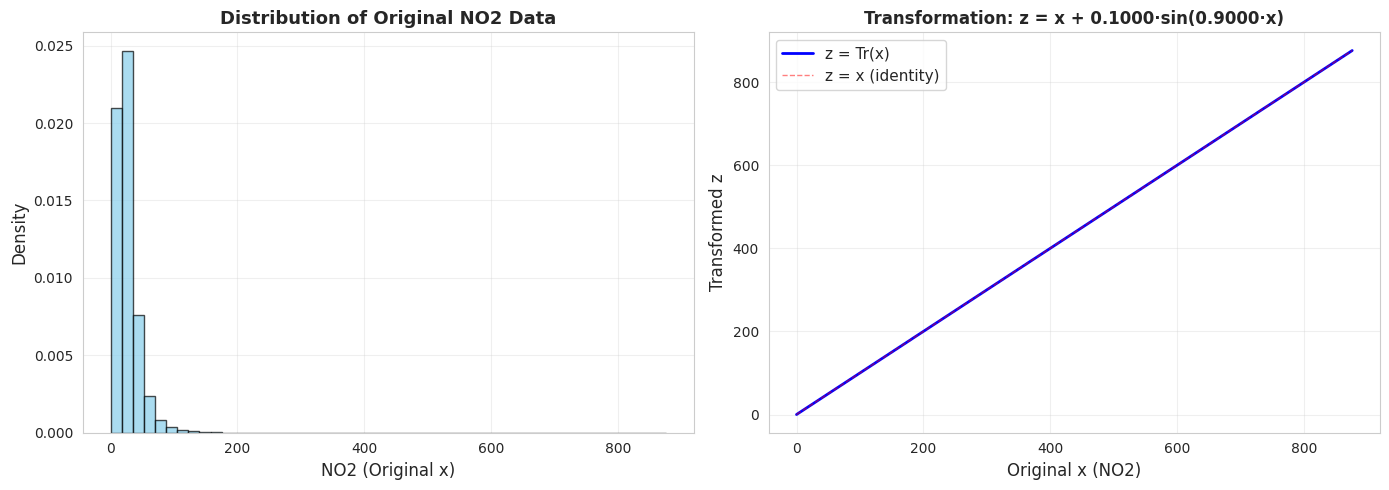

In [8]:
def transform(x, ar, br):
    """Transform x to z"""
    return x + ar * np.sin(br * x)

# Apply transformation
z = transform(x, ar, br)

print("Transformed Data (z) Statistics:")
print(f"  Mean: {np.mean(z):.4f}")
print(f"  Std:  {np.std(z):.4f}")
print(f"  Min:  {np.min(z):.4f}")
print(f"  Max:  {np.max(z):.4f}")

# Visualize the transformation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Original distribution
axes[0].hist(x, bins=50, density=True, alpha=0.7, color='skyblue', edgecolor='black')
axes[0].set_xlabel('NO2 (Original x)', fontsize=12)
axes[0].set_ylabel('Density', fontsize=12)
axes[0].set_title('Distribution of Original NO2 Data', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Transformation function
x_range = np.linspace(np.min(x), np.max(x), 1000)
z_range = transform(x_range, ar, br)
axes[1].plot(x_range, z_range, 'b-', linewidth=2, label='z = Tr(x)')
axes[1].plot(x_range, x_range, 'r--', linewidth=1, alpha=0.5, label='z = x (identity)')
axes[1].set_xlabel('Original x (NO2)', fontsize=12)
axes[1].set_ylabel('Transformed z', fontsize=12)
axes[1].set_title(f'Transformation: z = x + {ar:.4f}·sin({br:.4f}·x)', fontsize=12, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 3: Learn PDF Parameters

Learn parameters λ, μ, and c for:
$$\hat{p}(z) = c \cdot e^{-\lambda(z-\mu)^2}$$

In [9]:
def pdf_model(z, lambda_val, mu, c):
    """PDF model: p(z) = c * exp(-lambda*(z-mu)^2)"""
    return c * np.exp(-lambda_val * (z - mu)**2)

def negative_log_likelihood(params, z):
    """Negative log-likelihood for MLE"""
    lambda_val, mu, c = params

    # Constraints
    if lambda_val <= 0 or c <= 0:
        return 1e10

    # Calculate PDF
    pdf_values = pdf_model(z, lambda_val, mu, c)
    pdf_values = np.maximum(pdf_values, 1e-10)  # Avoid log(0)

    # Negative log-likelihood
    return -np.sum(np.log(pdf_values))

### Method 1: Maximum Likelihood Estimation (MLE)

In [10]:
# Initial parameter guesses
mu_init = np.mean(z)
sigma_init = np.std(z)
lambda_init = 1 / (2 * sigma_init**2)
c_init = 1 / np.sqrt(np.pi / lambda_init)

initial_params = [lambda_init, mu_init, c_init]

print("Initial Parameter Guesses:")
print(f"  λ₀ = {lambda_init:.6f}")
print(f"  μ₀ = {mu_init:.6f}")
print(f"  c₀ = {c_init:.6f}")

# Perform optimization
result = minimize(
    negative_log_likelihood,
    initial_params,
    args=(z,),
    method='L-BFGS-B',
    bounds=[(1e-6, None), (None, None), (1e-6, None)]
)

if result.success:
    lambda_mle, mu_mle, c_mle = result.x
    print("\n✓ Optimization Successful!")
    print("\nLearned Parameters (MLE):")
    print(f"  λ = {lambda_mle:.6f}")
    print(f"  μ = {mu_mle:.6f}")
    print(f"  c = {c_mle:.6f}")
    print(f"\nNegative Log-Likelihood: {result.fun:.2f}")
else:
    print(f"\n✗ Optimization Failed: {result.message}")

Initial Parameter Guesses:
  λ₀ = 0.001460
  μ₀ = 25.806857
  c₀ = 0.021557

✓ Optimization Successful!

Learned Parameters (MLE):
  λ = 0.000001
  μ = 26.032639
  c = 173376.233433

Negative Log-Likelihood: -5060485.36


### Method 2: Curve Fitting to Histogram

In [11]:
# Create histogram
counts, bin_edges = np.histogram(z, bins=50, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Fit curve
try:
    popt, pcov = curve_fit(
        pdf_model,
        bin_centers,
        counts,
        p0=[lambda_init, mu_init, c_init],
        bounds=([1e-6, -np.inf, 1e-6], [np.inf, np.inf, np.inf]),
        maxfev=10000
    )

    lambda_cf, mu_cf, c_cf = popt

    print("Learned Parameters (Curve Fitting):")
    print(f"  λ = {lambda_cf:.6f}")
    print(f"  μ = {mu_cf:.6f}")
    print(f"  c = {c_cf:.6f}")

    # Standard errors
    perr = np.sqrt(np.diag(pcov))
    print(f"\nStandard Errors:")
    print(f"  SE(λ) = {perr[0]:.6f}")
    print(f"  SE(μ) = {perr[1]:.6f}")
    print(f"  SE(c) = {perr[2]:.6f}")

except Exception as e:
    print(f"Curve fitting failed: {e}")

Learned Parameters (Curve Fitting):
  λ = 0.002057
  μ = 19.629610
  c = 0.026802

Standard Errors:
  SE(λ) = 0.000068
  SE(μ) = 0.208629
  SE(c) = 0.000293


### Method 3: Method of Moments

In [12]:
# Method of moments
mu_mm = np.mean(z)
var_mm = np.var(z)
lambda_mm = 1 / (2 * var_mm)
c_mm = np.sqrt(lambda_mm / np.pi)

print("Learned Parameters (Method of Moments):")
print(f"  λ = {lambda_mm:.6f}")
print(f"  μ = {mu_mm:.6f}")
print(f"  c = {c_mm:.6f}")

Learned Parameters (Method of Moments):
  λ = 0.001460
  μ = 25.806857
  c = 0.021557


## Step 4: Validate the Learned PDF

In [13]:
# Validate that PDF integrates to ~1
z_min, z_max = np.min(z) - 5*np.std(z), np.max(z) + 5*np.std(z)

integral, error = quad(
    pdf_model,
    z_min,
    z_max,
    args=(lambda_mle, mu_mle, c_mle)
)

print("PDF Validation:")
print(f"  Integration range: [{z_min:.2f}, {z_max:.2f}]")
print(f"  Integral value: {integral:.6f}")
print(f"  Integration error: {error:.2e}")
print(f"  Status: {'✓ Valid PDF' if abs(integral - 1.0) < 0.01 else '⚠ May need adjustment'}")

PDF Validation:
  Integration range: [-92.53, 968.55]
  Integral value: 146060482.226668
  Integration error: 1.62e-06
  Status: ⚠ May need adjustment


## Step 5: Visualize Results

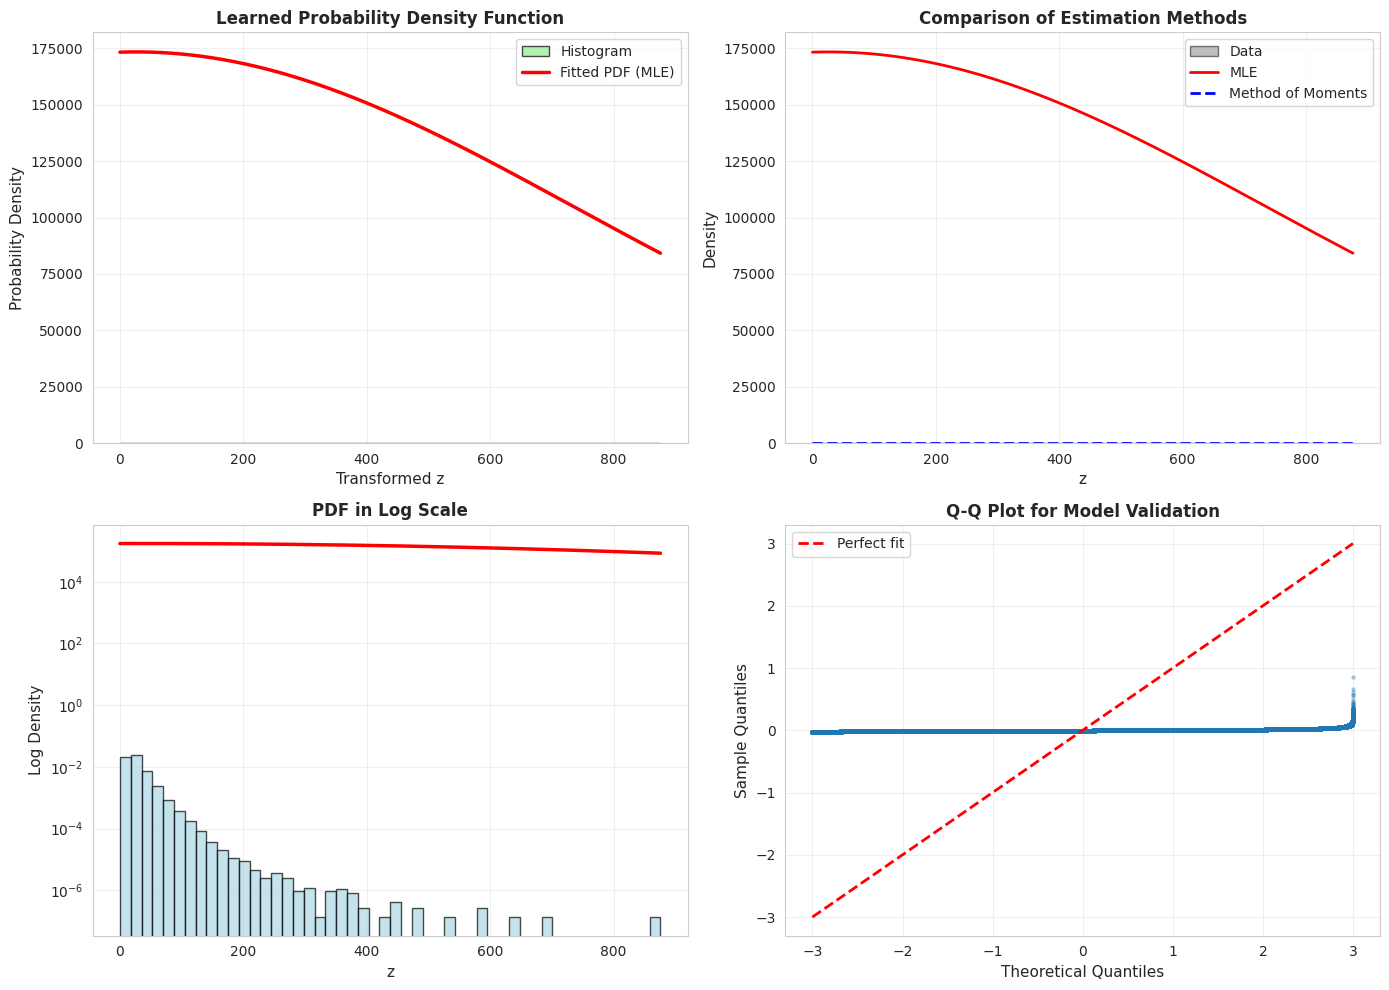

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Histogram with fitted PDF
ax1 = axes[0, 0]
ax1.hist(z, bins=50, density=True, alpha=0.7, color='lightgreen', edgecolor='black', label='Histogram')
z_plot = np.linspace(np.min(z), np.max(z), 1000)
pdf_values = pdf_model(z_plot, lambda_mle, mu_mle, c_mle)
ax1.plot(z_plot, pdf_values, 'r-', linewidth=2.5, label='Fitted PDF (MLE)')
ax1.set_xlabel('Transformed z', fontsize=11)
ax1.set_ylabel('Probability Density', fontsize=11)
ax1.set_title('Learned Probability Density Function', fontsize=12, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Comparison of methods
ax2 = axes[0, 1]
ax2.hist(z, bins=50, density=True, alpha=0.5, color='gray', edgecolor='black', label='Data')
ax2.plot(z_plot, pdf_model(z_plot, lambda_mle, mu_mle, c_mle), 'r-', linewidth=2, label='MLE')
ax2.plot(z_plot, pdf_model(z_plot, lambda_mm, mu_mm, c_mm), 'b--', linewidth=2, label='Method of Moments')
ax2.set_xlabel('z', fontsize=11)
ax2.set_ylabel('Density', fontsize=11)
ax2.set_title('Comparison of Estimation Methods', fontsize=12, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# Plot 3: Log-scale
ax3 = axes[1, 0]
ax3.hist(z, bins=50, density=True, alpha=0.7, color='lightblue', edgecolor='black')
ax3.plot(z_plot, pdf_values, 'r-', linewidth=2.5)
ax3.set_yscale('log')
ax3.set_xlabel('z', fontsize=11)
ax3.set_ylabel('Log Density', fontsize=11)
ax3.set_title('PDF in Log Scale', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3, which='both')

# Plot 4: Q-Q Plot
ax4 = axes[1, 1]
z_sorted = np.sort(z)
z_standardized = np.sqrt(lambda_mle) * (z_sorted - mu_mle)
n = len(z_sorted)
theoretical_quantiles = np.linspace(-3, 3, n)
ax4.scatter(theoretical_quantiles, z_standardized, alpha=0.3, s=5)
ax4.plot(theoretical_quantiles, theoretical_quantiles, 'r--', linewidth=2, label='Perfect fit')
ax4.set_xlabel('Theoretical Quantiles', fontsize=11)
ax4.set_ylabel('Sample Quantiles', fontsize=11)
ax4.set_title('Q-Q Plot for Model Validation', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 6: Final Results - Parameters to Submit

In [15]:
print("=" * 70)
print("FINAL RESULTS - SUBMIT THESE PARAMETERS")
print("=" * 70)
print(f"\nRoll Number: {ROLL_NUMBER}")
print(f"\nTransformation Parameters:")
print(f"  ar = {ar:.6f}")
print(f"  br = {br:.6f}")
print(f"\nLearned PDF Parameters (Maximum Likelihood Estimation):")
print(f"  λ (lambda) = {lambda_mle:.6f}")
print(f"  μ (mu)     = {mu_mle:.6f}")
print(f"  c          = {c_mle:.6f}")
print(f"\nPDF Equation:")
print(f"  p̂(z) = {c_mle:.6f} × exp(-{lambda_mle:.6f} × (z - {mu_mle:.6f})²)")
print("=" * 70)

# Create summary dictionary
results = {
    'roll_number': ROLL_NUMBER,
    'ar': ar,
    'br': br,
    'lambda': lambda_mle,
    'mu': mu_mle,
    'c': c_mle
}

print("\nResults as dictionary:")
print(results)

FINAL RESULTS - SUBMIT THESE PARAMETERS

Roll Number: 102317147

Transformation Parameters:
  ar = 0.100000
  br = 0.900000

Learned PDF Parameters (Maximum Likelihood Estimation):
  λ (lambda) = 0.000001
  μ (mu)     = 26.032639
  c          = 173376.233433

PDF Equation:
  p̂(z) = 173376.233433 × exp(-0.000001 × (z - 26.032639)²)

Results as dictionary:
{'roll_number': 102317147, 'ar': 0.1, 'br': 0.8999999999999999, 'lambda': np.float64(1e-06), 'mu': np.float64(26.032638506451274), 'c': np.float64(173376.23343312592)}


## Additional Analysis: Parameter Sensitivity

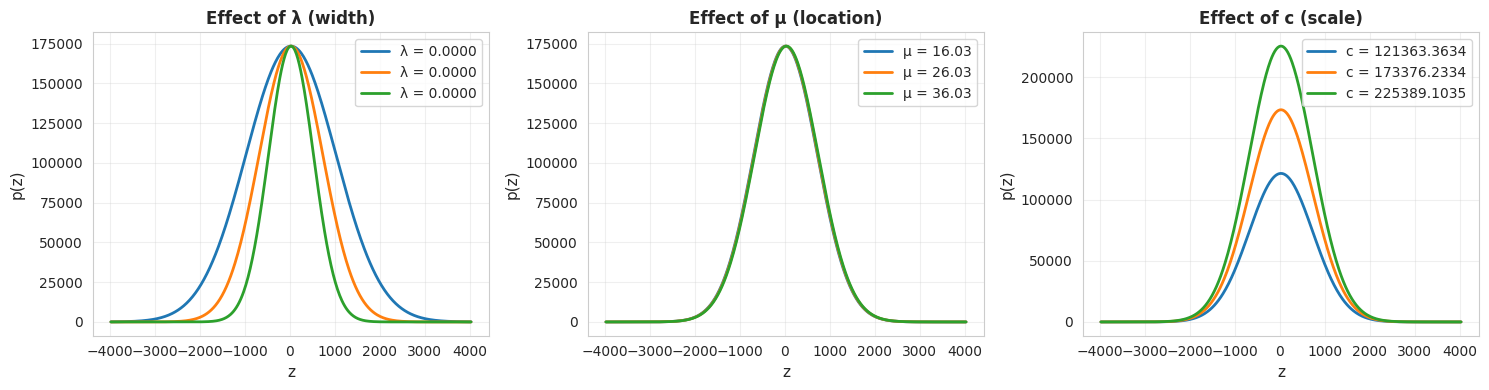

In [16]:
# Analyze how parameters affect the PDF shape
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

z_range = np.linspace(mu_mle - 4/np.sqrt(lambda_mle), mu_mle + 4/np.sqrt(lambda_mle), 500)

# Effect of λ
for lam in [lambda_mle*0.5, lambda_mle, lambda_mle*2]:
    axes[0].plot(z_range, pdf_model(z_range, lam, mu_mle, c_mle),
                label=f'λ = {lam:.4f}', linewidth=2)
axes[0].set_xlabel('z', fontsize=11)
axes[0].set_ylabel('p(z)', fontsize=11)
axes[0].set_title('Effect of λ (width)', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Effect of μ
for m in [mu_mle - 10, mu_mle, mu_mle + 10]:
    axes[1].plot(z_range, pdf_model(z_range, lambda_mle, m, c_mle),
                label=f'μ = {m:.2f}', linewidth=2)
axes[1].set_xlabel('z', fontsize=11)
axes[1].set_ylabel('p(z)', fontsize=11)
axes[1].set_title('Effect of μ (location)', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Effect of c
for cc in [c_mle*0.7, c_mle, c_mle*1.3]:
    axes[2].plot(z_range, pdf_model(z_range, lambda_mle, mu_mle, cc),
                label=f'c = {cc:.4f}', linewidth=2)
axes[2].set_xlabel('z', fontsize=11)
axes[2].set_ylabel('p(z)', fontsize=11)
axes[2].set_title('Effect of c (scale)', fontsize=12, fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()